In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pymc3 as pm

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#One dimensional model for seismic displacement

#Defining main parameters of the model
rho0 = 1800 #Density of the homogeneous medium in kg/m^3, as taken from Beker's thesis paper, pg. 84
alpha = 0.31 #Parameter used in Beker's paper to determine primary wave speed pg. 84
beta = 0.25 #Parameter used in Beker's paper to determine primary wave speed pg 84.
nu = 0.25 #Poisson ratio as taken from Beker's thesis paper pg. 84

#Calculating the wave speeds using above paramters
CP = ((rho0/1000) / alpha)**(1.0 / beta) #Calculating primary wave speed using equation from Beker's paper, pg. 84
CS = np.sqrt((1-2*nu)/(2-2*nu)) * CP #Calculating secondary wave speed using equation from Beker's paper, pg. 84
Root = np.roots([1, -8, 8 * ((2 - nu)/(1 - nu)), -8 / (1 - nu)]) #Calculating the the ratio of the R wave speed to the p wave speed squared using equation found in Harm's and Beker's paper, pg. 20 in Beker's paper
for i in Root:
    if 0<i<1:
        CR = np.sqrt(CS**2 *i) #calculating R wave speed

#Calculating seismic displacement using equation from Harm's paper "Terrestial Gravity Fluctuations", pg. 31 
def xi_horizontal(x,z,t,f,phi): #defining Horizontal displacement for a Rayleigh wave, where x is the position along the x-axis, z is the depth in the medium, t is the time, f is the frequency of the wave, and phi is the phase shift of the wave
    omega = 2*np.pi*f #calculating the angular frequency
    ke = omega / CR #Calculating horizontal wave number of the Rayleigh wave
    ks = omega / CS #Calculatin the secondary wave number of the Rayleigh wave
    kp = omega / CP #Calculating the primary wave number of the Rayleigh wave
    q_z_s = np.sqrt(ke**2 - ks**2) #Calculating wave parameter used in Harm's model, pg. 31
    q_z_p = np.sqrt(ke**2 - kp**2) #Calculating wave parameter used in Harm's model, pg. 31
    zeta = np.sqrt(q_z_p / q_z_s) #Calculating wave parameter used in Harm's model, pg. 32
    a = (1.0 / 2**(-2.72)) * f**(-2.72) #Calculating the frequency dependent amplitude
    return a * (ke * np.exp(q_z_p * z ) - zeta * q_z_s * np.exp(q_z_s * z)) * np.sin(ke * x - omega * t) #Calculating the horizontal dislacement

def xi_vertical(x,z,t,f,phi):
    omega = 2*np.pi*f #calculating the angular frequency
    ke = omega / CR #Calculating horizontal wave number of the Rayleigh wave
    ks = omega / CS #Calculatin the secondary wave number of the Rayleigh wave
    kp = omega / CP #Calculating the primary wave number of the Rayleigh wave
    q_z_s = np.sqrt(ke**2 - ks**2) #Calculating wave parameter used in Harm's model, pg. 31
    q_z_p = np.sqrt(ke**2 - kp**2) #Calculating wave parameter used in Harm's model, pg. 31
    zeta = np.sqrt(q_z_p / q_z_s) #Calculating wave parameter used in Harm's model, pg. 32
    a = (1.0 / 2**(-2.72)) * f**(-2.72) #Calculating the frqeuency dependent amplitude
    return a * (q_z_p * np.exp(q_z_p * z ) - zeta * ke * np.exp(q_z_s * z)) * np.cos(ke * x - omega * t) #Calculating the vertical displacement


In [3]:
#Calculating the seismic NN from the seismic displacement in one dimension

#Defining calculation parameters

G = 6.67e-11 #Newton's gravitational constant
xlist = np.linspace(0, 500, 501) #List of x-values for the seismic nn to be calculated at
snnhorizontal = np.zeros(len(xlist)) #Defining array to place the contributions of the horizontal displacement of each point to the Newtonian noise
snnvertical = np.zeros(len(xlist)) #Defining array to place the the contributions of the vertical displacement of each point to the Newtonian noise

#Calculating the Seismic Newtonian Noise using equation (4.13) from Beker's thesis paper on pg. 92
def seisnn(z,t,f,phi,x0): #Calculating the seismic newtonian noise for a single point in time where z is depth of the points, t is time, f is the frequency of the Rayleigh wave, phi is the phase shift of the wave, and x0 is the test mass position
    V = 3 * (500 / len(xlist)) * 10 #Calculating the volume of each element
    for i, xn in enumerate(xlist):
        r = xn - x0
        snnhorizontal[i] = G * rho0 * (1.0 / r**3) * (-2) * xi_horizontal(xn,z,t,f,phi) * V #Calculating the horizontal displacement contribution
        snnvertical[i] = G * rho0 * (1.0 / r**3) * xi_vertical(xn,z,t,f,phi) * V #Calculating the vertical displacemet contribution
    snnhorizontal_total = np.sum(snnhorizontal) #Summing the horizontal displacement contribution of each point
    snnvertical_total = np.sum(snnvertical) #Summing the vertical displacement contribution of each point
    snntotal = np.sqrt(snnhorizontal_total**2 + snnvertical_total**2) #calculating magnitude of the newtonian noise
    return snntotal

In [4]:
tlist = np.linspace(0,3, 100)

seisnnlist = np.zeros(len(tlist))

for i, tn in enumerate(tlist):
    seisnnlist[i]= seisnn(0,tn,3,0,250.5)

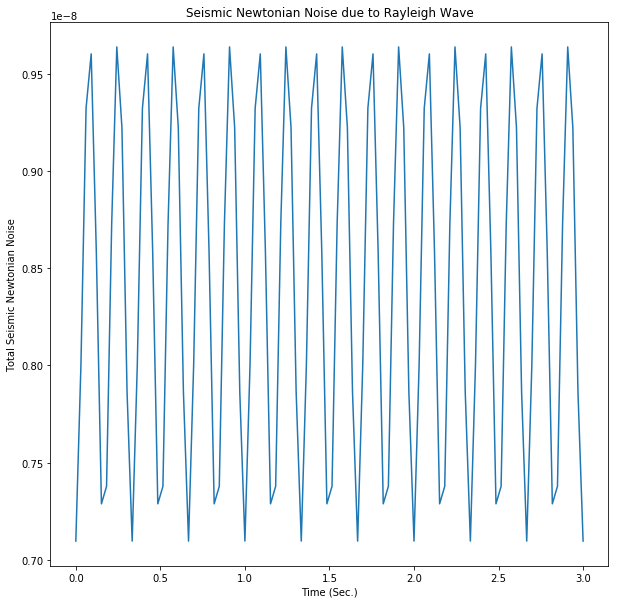

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, xlabel='Time (Sec.)', ylabel='Total Seismic Newtonian Noise', title='Seismic Newtonian Noise due to Rayleigh Wave')
ax.plot(tlist, seisnnlist)

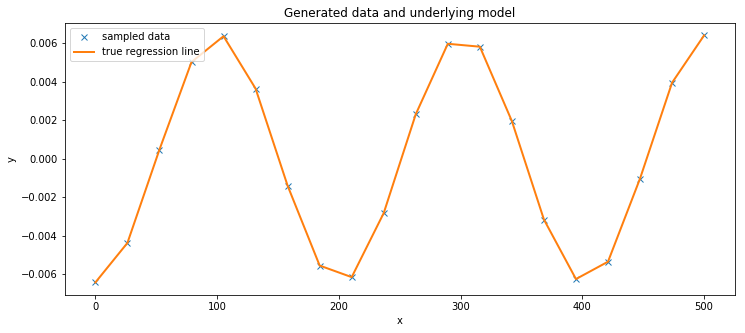

In [86]:
#The following Gaussian Process Regression models were constructed by exactly following the model detailed in Daniel William's Gaussian Process tutorial 

#Creating GP Regression model for the vertical displacement

#Defining Training data

x=np.linspace(0,500,20)
x2=np.linspace(0,500,501)
y=xi_vertical(x, 0, 3, 3, 0)
y2=xi_vertical(x2,0,3,3,0)
data = dict(x=x, y=y)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, y, label='true regression line', lw=2.)
plt.legend(loc=0);


In [87]:
with pm.Model() as model:
    mean = pm.Normal('mean', 75, 50)
    ls=pm.Normal("ls", 120, 20)
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0, .000001)
    y_ = gp.marginal_likelihood("y", X=x[::,None], y=y, noise=sigma)

In [88]:
with model:
    mp = pm.find_MAP()

logp = 74.185, ||grad|| = 9.4088e-06: 100%|██████████| 12/12 [00:00<00:00, 347.93it/s]  


In [89]:
h = np.zeros(501)
for i, k in enumerate(h):
    h[i] = i + 0.5
    
x_new = np.linspace(0,500,501)[::, None]

In [90]:
mu_vertical, var=gp.predict(x_new, point=mp, diag=True)
sd = np.sqrt(var)

Text(0.5,1,'Difference between mean function and actual points')

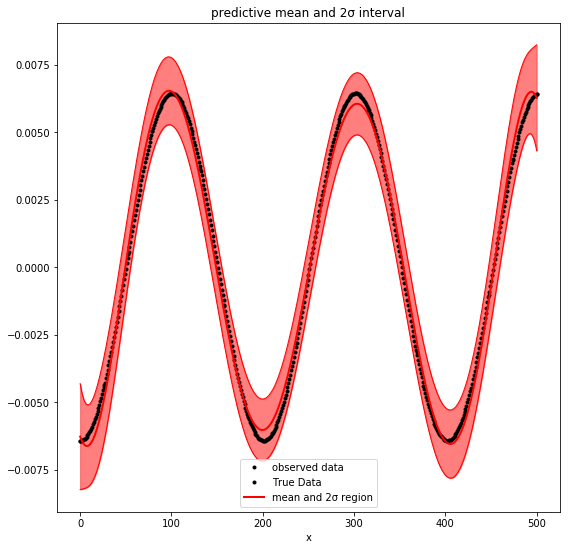

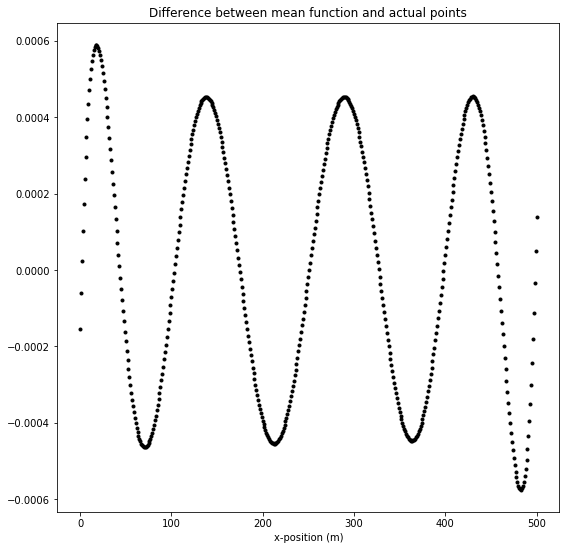

In [91]:
# draw plot
fig = plt.figure(figsize=(9,9)); ax = fig.gca()

# plot original data and true function
plt.plot(x, y, 'ok', ms=3, alpha=1.0, label="observed data");
#plt.plot(x, f_true, "dodgerblue", lw=3, label="true f");

plt.plot(x2,y2,'ok', ms=3, alpha=1.0, label='True Data')

# plot mean and 2σ intervals
plt.plot(x_new, mu_vertical, 'r', lw=2, label="mean and 2σ region");
plt.plot(x_new, mu_vertical + 2*sd, 'r', lw=1); plt.plot(x_new, mu_vertical - 2*sd, 'r', lw=1);
plt.fill_between(x_new.flatten(), mu_vertical - 2*sd, mu_vertical + 2*sd, color="r", alpha=0.5)

plt.xlabel("x");# plt.ylim([-13,13]);
plt.title("predictive mean and 2σ interval"); plt.legend();

fig2 = plt.figure(figsize=(9,9)); ax=fig.gca()

plt.plot(x_new, y2-mu_vertical, 'ok', ms=3, alpha=1.0, label="Difference in data")
plt.xlabel("x-position (m)")
plt.title("Difference between mean function and actual points")

In [88]:
with model:
    f_pred = gp.conditional("f_pred", x_new)

In [89]:
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:38<00:00, 25.95it/s]


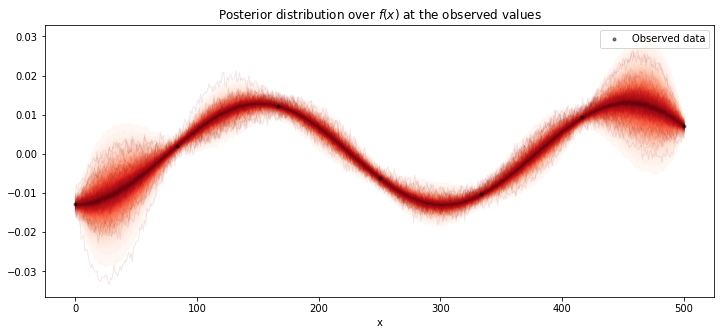

In [90]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], x_new);

plt.plot(x, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("x"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

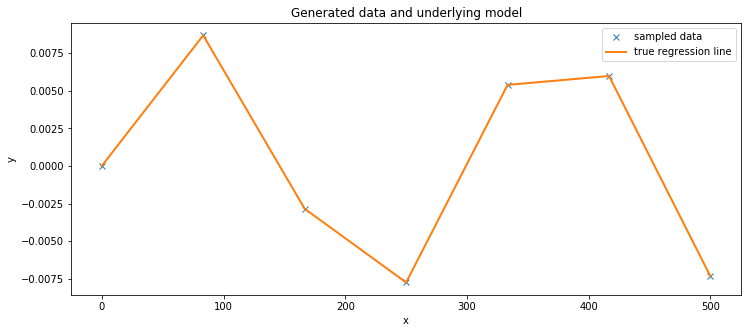

In [91]:
#Creating GP Regression model for the horizontal displacement

#Defining Training data

x=np.linspace(0,500,7)

y=xi_horizontal(x, 0, 3, 2, 0)

data = dict(x=x, y=y)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, y, label='true regression line', lw=2.)
plt.legend(loc=0);

In [92]:
with pm.Model() as model:
    ls = pm.Normal('ls', 120,20)
    
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0, .000001)
    y_ = gp.marginal_likelihood("y", X=x[::,None], y=y, noise=sigma)

In [93]:
with model:
    mp = pm.find_MAP()

logp = 7.5249, ||grad|| = 0.092026: 100%|██████████| 7/7 [00:00<00:00, 422.30it/s]


In [94]:
h = np.zeros(500)
for i, k in enumerate(h):
    h[i] = i + 0.5
    
x_new = np.linspace(0,500,501)[::, None]

In [95]:
mu_horizontal, var=gp.predict(x_new, point=mp, diag=True)
sd = np.sqrt(var)

Text(0.5,1,'Difference between mean function and actual points')

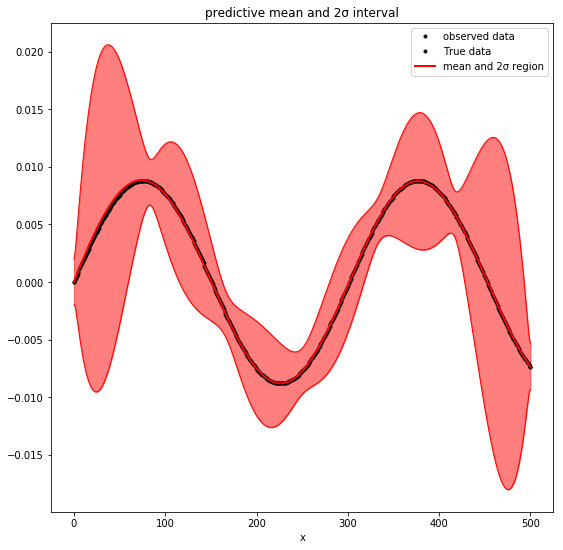

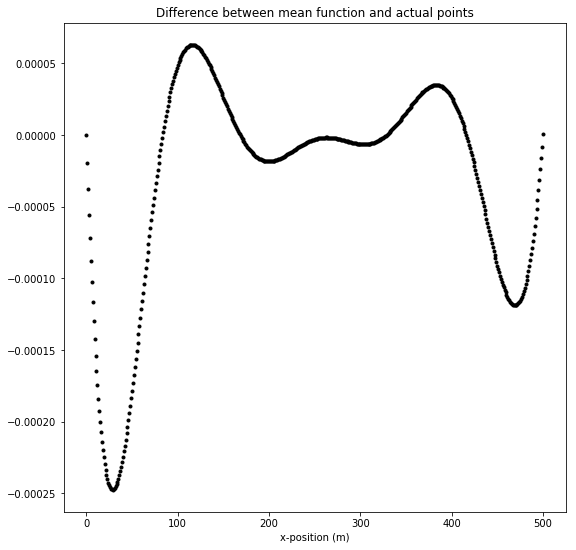

In [97]:
# draw plot
fig = plt.figure(figsize=(9,9)); ax = fig.gca()

# plot original data and true function
plt.plot(x, y, 'ok', ms=3, alpha=1.0, label="observed data");
#plt.plot(x, f_true, "dodgerblue", lw=3, label="true f");

plt.plot(x2,y2,'ok', ms=3, alpha=1.0, label='True data')

# plot mean and 2σ intervals
plt.plot(x_new, mu_horizontal, 'r', lw=2, label="mean and 2σ region");
plt.plot(x_new, mu_horizontal + 2*sd, 'r', lw=1); plt.plot(x_new, mu_horizontal - 2*sd, 'r', lw=1);
plt.fill_between(x_new.flatten(), mu_horizontal - 2*sd, mu_horizontal + 2*sd, color="r", alpha=0.5)

plt.xlabel("x");# plt.ylim([-13,13]);
plt.title("predictive mean and 2σ interval"); plt.legend();

fig2 = plt.figure(figsize=(9,9)); ax=fig.gca()

plt.plot(x_new, y2-mu_horizontal, 'ok', ms=3, alpha=1.0, label="Difference in data")
plt.xlabel("x-position (m)")
plt.title("Difference between mean function and actual points")

In [98]:
with model:
    f_pred = gp.conditional("f_pred", x_new)

In [99]:
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:44<00:00, 22.56it/s]


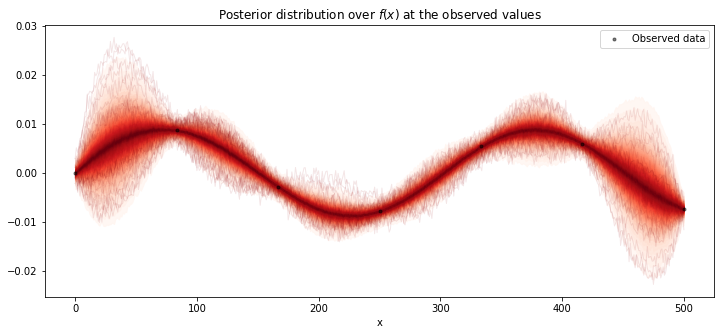

In [100]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], x_new);

plt.plot(x, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("x"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [8]:
#Redefining Seismic Newtonain Noise model to make it possible to calculate it from the output arrays of the GP Model

snnhorizontal = np.zeros(len(x_new)) #Defining array to place the contributions of the horizontal displacement of each point to the Newtonian noise
snnvertical = np.zeros(len(x_new)) #Defining array to place the the contributions of the vertical displacement of each point to the Newtonian noise

#Calculating the Seismic Newtonian Noise using equation (4.13) from Beker's thesis paper on pg. 92
def seisnn_gp(z,t,f,phi,x0): #Calculating the seismic newtonian noise for a single point in time where z is depth of the points, t is time, f is the frequency of the Rayleigh wave, phi is the phase shift of the wave, and x0 is the test mass position
    V = 3 * (500 / len(x_new)) * 10 #Calculating the volume of each element
    for i, xn in enumerate(x_new):
        r = xn - x0
        snnhorizontal[i] = G * rho0 * (1.0 / r**3) * (-2) * mu_horizontal[i] * V #Calculating the horizontal displacement contribution
        snnvertical[i] = G * rho0 * (1.0 / r**3) * mu_vertical[i] * V #Calculating the vertical displacemet contribution
    snnhorizontal_total = np.sum(snnhorizontal) #Summing the horizontal displacement contribution of each point
    snnvertical_total = np.sum(snnvertical) #Summing the vertical displacement contribution of each point
    snntotal = np.sqrt(snnhorizontal_total**2 + snnvertical_total**2) #calculating magnitude of the newtonian noise
    return snntotal

In [111]:
seisnn(0,3,2,0,250.5)

1.040235070973347e-08

In [116]:
seisnn(0,3,2,0,250.5)

1.0424703559662379e-08

In [9]:
#Model to calculate the Seismic Newtonian Noise from the GP Model for a time series
t2list = np.linspace(0,3,100)

seisnngplist=np.zeros(len(t2list))

for i, tn in enumerate(t2list):
    x=np.linspace(0,500,7)
    y=xi_vertical(x, 0, tn, 3, 0)
    data = dict(x=x, y=y)
    with pm.Model() as model:
        ls=pm.Normal("ls", 120, 20)
        # Specify the covariance function.
        cov_func = pm.gp.cov.ExpQuad(1, ls)
        # Specify the GP.  The default mean function is `Zero`.
        gp = pm.gp.Marginal(cov_func=cov_func)
        #
        sigma = pm.Normal("sigma", 0, .000001)
        y_ = gp.marginal_likelihood("y", X=x[::,None], y=y, noise=sigma)
    with model:
        mp = pm.find_MAP()
    x_new = np.linspace(0,500,501)[::, None]
    mu_vertical, var=gp.predict(x_new, point=mp, diag=True)
    sd = np.sqrt(var)
    x=np.linspace(0,500,7)
    y=xi_horizontal(x, 0, tn, 3, 0)
    data = dict(x=x, y=y)
    with pm.Model() as model:
        ls = pm.Normal('ls', 120,20)
        # Specify the covariance function.
        cov_func = pm.gp.cov.ExpQuad(1, ls)
        # Specify the GP.  The default mean function is `Zero`.
        gp = pm.gp.Marginal(cov_func=cov_func)
        # 
        sigma = pm.Normal("sigma", 0, .000001)
        y_ = gp.marginal_likelihood("y", X=x[::,None], y=y, noise=sigma)
    with model:
        mp = pm.find_MAP()
    mu_horizontal, var=gp.predict(x_new, point=mp, diag=True)
    sd = np.sqrt(var)
    seisnngplist[i] = seisnn_gp(0,tn,2,0,250.5)

logp = 7.5233, ||grad|| = 0.091941: 100%|██████████| 7/7 [00:00<00:00, 412.88it/s]
logp = 7.5188, ||grad|| = 0.091509: 100%|██████████| 8/8 [00:00<00:00, 395.64it/s]
logp = 7.5191, ||grad|| = 0.091584: 100%|██████████| 8/8 [00:00<00:00, 432.63it/s]
logp = 7.5207, ||grad|| = 0.091675: 100%|██████████| 8/8 [00:00<00:00, 435.66it/s]
logp = 7.5124, ||grad|| = 0.091016: 100%|██████████| 8/8 [00:00<00:00, 468.87it/s]
logp = 7.5238, ||grad|| = 0.091938: 100%|██████████| 7/7 [00:00<00:00, 477.30it/s]
logp = 7.511, ||grad|| = 0.090902: 100%|██████████| 8/8 [00:00<00:00, 437.21it/s]
logp = 7.5245, ||grad|| = 0.091991: 100%|██████████| 7/7 [00:00<00:00, 466.41it/s]
logp = 7.5166, ||grad|| = 0.091374: 100%|██████████| 8/8 [00:00<00:00, 404.38it/s]
logp = 7.5219, ||grad|| = 0.091772: 100%|██████████| 7/7 [00:00<00:00, 359.32it/s]
logp = 7.5226, ||grad|| = 0.091881: 100%|██████████| 7/7 [00:00<00:00, 377.26it/s]
logp = 7.5191, ||grad|| = 0.091537: 100%|██████████| 8/8 [00:00<00:00, 398.72it/s]
logp 

logp = 7.5202, ||grad|| = 0.091635: 100%|██████████| 8/8 [00:00<00:00, 382.98it/s]
logp = 7.5233, ||grad|| = 0.091941: 100%|██████████| 7/7 [00:00<00:00, 371.04it/s]
logp = 7.5188, ||grad|| = 0.091509: 100%|██████████| 8/8 [00:00<00:00, 436.81it/s]


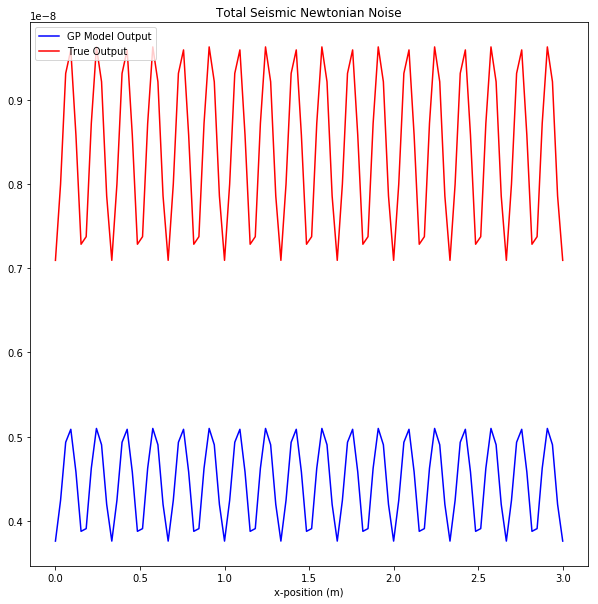

In [12]:
fig = plt.figure(figsize=(10,10))
plt.plot(t2list, seisnngplist, label = 'GP Model Output', color = 'blue')
plt.plot(tlist, seisnnlist, label = 'True Output', color = 'red')
plt.xlabel("x-position (m)")
plt.title("Total Seismic Newtonian Noise")
plt.legend(loc = 'upper left');